# Filter and trim messages using the built-in MessagesState

## Messages without trimming or filtering

In [5]:
# Import libraries
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import display, Image
from langchain_openai import ChatOpenAI

In [8]:
# Define node
def chat_model(state: MessagesState) -> MessagesState:
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    return {"messages": llm.invoke(state["messages"])}

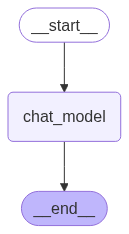

In [9]:
# Define Graph
graphBuilder = StateGraph(MessagesState)
graphBuilder.add_node("chat_model", chat_model)

graphBuilder.add_edge(START, "chat_model")
graphBuilder.add_edge("chat_model", END)

graph = graphBuilder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# Test the setup
messages = [HumanMessage(content="Hello!", name="Arnab", id=1), 
            AIMessage(content="Hi there!", name="model", id=2), 
            HumanMessage(content="How are you?", name="Arnab", id=3), 
            AIMessage(content="I am doing great!", name="model", id=4),
            HumanMessage(content="What are the must see places in Texas?", name="Arnab", id=5)]

output = graph.invoke({"messages": messages})

for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: model

I am doing great!
================================ Human Message =================================
Name: Arnab

What are the must see places in Texas?
================================== Ai Message ==================================

Texas is a vast state with a diverse range of attractions, from natural wonders to cultural landmarks. Here are some must-see places in Texas:

1. **The Alamo** (San Antonio): A historic site and symbol of Texas independence, the Alamo is a must-visit for history enthusiasts.

2. **Big Bend National Park**: Located in West Texas, this park offers stunning desert landscapes, hiking trails, and opportunities for stargazing.

3. **San Antonio River Walk**: A vibrant network of walkways along the San Antonio River, lined with shops, restaurants, and cultural attractions.

4. **Austin**: Known for its live music scene, Austin is home to numerous music festivals, eclecti

## Filter messages using Reducers

In [12]:
# Import Libraries
from langchain_core.messages import RemoveMessage

In [13]:
# Define nodes
def filter_messages(state: MessagesState) -> MessagesState:
    messages_to_remove = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": messages_to_remove}

def chat_model(state: MessagesState) -> MessagesState:
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    return {"messages": llm.invoke(state["messages"])}

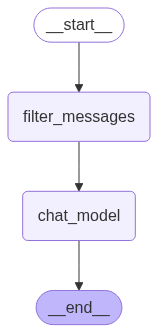

In [14]:
# Define Graph
graphBuilder = StateGraph(MessagesState)
graphBuilder.add_node("filter_messages", filter_messages)
graphBuilder.add_node("chat_model", chat_model)

graphBuilder.add_edge(START, "filter_messages")
graphBuilder.add_edge("filter_messages", "chat_model")
graphBuilder.add_edge("chat_model", END)

graph = graphBuilder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
# Test the setup
messages = [HumanMessage(content="Hello!", name="Arnab", id=1), 
            AIMessage(content="Hi there!", name="model", id=2), 
            HumanMessage(content="How are you?", name="Arnab", id=3), 
            AIMessage(content="I am doing great!", name="model", id=4),
            HumanMessage(content="What are the must see places in Texas?", name="Arnab", id=5)]

output = graph.invoke({"messages": messages})

for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: model

I am doing great!
================================ Human Message =================================
Name: Arnab

What are the must see places in Texas?
================================== Ai Message ==================================

Texas is a vast state with a diverse range of attractions, from natural wonders to cultural landmarks. Here are some must-see places in Texas:

1. **The Alamo** (San Antonio): A historic site and symbol of Texas independence, the Alamo is a must-visit for history enthusiasts.

2. **Big Bend National Park**: Located in West Texas, this park offers stunning desert landscapes, hiking trails, and opportunities for stargazing.

3. **San Antonio River Walk**: A vibrant network of walkways along the San Antonio River, lined with shops, restaurants, and cultural attractions.

4. **Austin**: Known for its live music scene, Austin is home to numerous music festivals, eclecti

In [17]:
# Append the output to the messages
messages.append(output["messages"][-1])

## Filter messages before feeding in LLM


In [18]:
# Define nodes
def chat_model(state: MessagesState) -> MessagesState:
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    return {"messages": llm.invoke(state["messages"][-1:])}

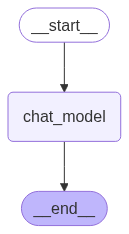

In [19]:
# Define graph
graphBuilder = StateGraph(MessagesState)
graphBuilder.add_node("chat_model", chat_model)

graphBuilder.add_edge(START, "chat_model")
graphBuilder.add_edge("chat_model", END)

graph = graphBuilder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
# Test the setup
messages.append(HumanMessage(content="What is the capital of Texas?", name="Arnab"))
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================
Name: Arnab

Hello!
================================== Ai Message ==================================
Name: model

Hi there!
================================ Human Message =================================
Name: Arnab

How are you?
================================== Ai Message ==================================
Name: model

I am doing great!
================================ Human Message =================================
Name: Arnab

What are the must see places in Texas?
================================== Ai Message ==================================

Texas is a vast state with a diverse range of attractions, from natural wonders to cultural landmarks. Here are some must-see places in Texas:

1. **The Alamo** (San Antonio): A historic site and symbol of Texas independence, the Alamo is a must-visit for history enthusiasts.

2. **Big Bend National Park**: Located in West Texas, this park offers stunning des

In [21]:
# Append the output to the messages
messages.append(output["messages"][-1])

## Restrict LLM token usage using Trim Messages

In [24]:
# Import required libraries
from langchain_core.messages import trim_messages

In [28]:
# Test trim messages
trimmed_messages = trim_messages(messages, 
                                max_tokens=100, 
                                strategy="last",
                                token_counter=ChatOpenAI(model="gpt-4o"),
                                allow_partial=False)

for m in trimmed_messages:
    m.pretty_print()

================================ Human Message =================================
Name: Arnab

What is the capital of Texas?
================================== Ai Message ==================================

The capital of Texas is Austin.


In [29]:
# Define nodes
def chat_model(state: MessagesState) -> MessagesState:
    messages = trim_messages(state["messages"],
                             max_tokens=100, 
                             strategy="last",
                             token_counter=ChatOpenAI(model="gpt-4o"),
                             allow_partial=False)
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    return {"messages": llm.invoke(messages)}

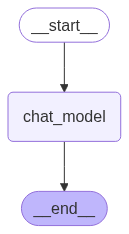

In [30]:
# Define graph
graphBuilder = StateGraph(MessagesState)
graphBuilder.add_node("chat_model", chat_model)

graphBuilder.add_edge(START, "chat_model")
graphBuilder.add_edge("chat_model", END)

graph = graphBuilder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# Test the setup
messages.append(HumanMessage(content="What are the recommended places to see in Austin?", name="Arnab"))
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================
Name: Arnab

Hello!
================================== Ai Message ==================================
Name: model

Hi there!
================================ Human Message =================================
Name: Arnab

How are you?
================================== Ai Message ==================================
Name: model

I am doing great!
================================ Human Message =================================
Name: Arnab

What are the must see places in Texas?
================================== Ai Message ==================================

Texas is a vast state with a diverse range of attractions, from natural wonders to cultural landmarks. Here are some must-see places in Texas:

1. **The Alamo** (San Antonio): A historic site and symbol of Texas independence, the Alamo is a must-visit for history enthusiasts.

2. **Big Bend National Park**: Located in West Texas, this park offers stunning des